In [46]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import loadmat
from scipy.special import gamma
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.patches as patches
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [47]:
def embedding_fit_metrics(original_distances, embedded_distances):
    """
    Computes the following goodness-of-fit metrics for an embedding:
    1. Spearman's Rank Correlation
    2. Pearson Correlation
    3. R^2 value (MSE to the line y = x)

    Parameters:
    original_distances (array-like): Pairwise distances in the original space.
    embedded_distances (array-like): Pairwise distances in the embedded space.

    Returns:
    dict: A dictionary containing Spearman's rho, Pearson's r, and R^2 value.
    """
    
    # Ensure input is NumPy arrays
    original_distances = np.array(original_distances)
    embedded_distances = np.array(embedded_distances)
    
    # Compute Spearman's rank correlation
    spearman_corr, _ = spearmanr(original_distances, embedded_distances)
    
    # Compute Pearson correlation
    pearson_corr, _ = pearsonr(original_distances, embedded_distances)
    
    # Compute R^2 value (MSE to the line y = x)
    r2 = r2_score(original_distances, embedded_distances)
    
    return {
        "Spearman Rank Correlation": spearman_corr,
        "Pearson Correlation": pearson_corr,
        "R^2 Value": r2
    }

In [48]:
def vol(R, D):
    c = 2*np.power(np.pi, 0.5*D)
    itg = integrate.quad(lambda x: np.power(np.sinh(x), D-1), 0.0, R)[0]
    return c*itg

def sample_r(R, D):
    rmin = 0.0; rmax = R; rc = 0.5*R
    V_tot = vol(R, D); uc = vol(rc, D)/V_tot
    u = np.random.uniform()
    while(np.abs(u-uc)>1e-4):
        if uc < u:
            rmin = rc
            rc = 0.5*(rc + rmax)
            uc = vol(rc, D)/V_tot
        elif u < uc:
            rmax = rc
            rc = 0.5*(rc + rmin)
            uc = vol(rc, D)/V_tot
    return rc

#uniformly sample a point in hyperbolic space out to Rmax
#return point in poincare coords
def h_samp(rm, D):
    direction = np.random.normal(size=D)
    direction = direction/np.sqrt(np.sum(np.square(direction)))
    #th = 2.0*np.pi*np.random.uniform()
    r_p = sample_r(rm, 2)
    return np.tanh(r_p/2.0)*direction
    #return np.tanh(r_p/2.0)*np.asarray([np.cos(th), np.sin(th)])

def pdist(p1, p2):
    inv = 2.0*(p1-p2).dot(p1-p2)/((1-p1.dot(p1))*(1-p2.dot(p2)))
    return np.arccosh(1.0 + inv)

In [52]:
class HMDS():
    def __init__(self, deltaij, D, a=2, b=0.5, sig_lam=10, tolerance=1e-10):
        ## Parameters ##
        self.deltaij = tf.constant(deltaij, dtype=tf.float32)
        self.N = tf.constant(deltaij.shape[0])
        self.D = tf.constant(D)

        ## Variables ##
        self.euc = tf.Variable(tf.random.normal(shape=(self.N, self.D), mean=0.0, stddev=.0001), dtype=tf.float32)
        self.log_sig = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), dtype=tf.float32)
        self.log_lam = tf.Variable(0, dtype=tf.float32)

        ## Constraints ##
        self.time = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), shape=(self.N,1), trainable=False)

        ## Model Hyperparameters ##
        self.a = a
        self.b = b
        self.sig_lam = sig_lam

        ## Optimization Hyperparameters ##
        self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
        self.tolerance = tolerance

        ## Optimization Results ##
        self.loss_curve = []
        self.lambda_curve = []
        
    @tf.function
    def constraint_time(self):
        return tf.expand_dims(tf.sqrt(tf.add(1.0,tf.square(tf.norm(self.euc,axis=1)))),1)

    @tf.function
    def pairwise_dist_lorentz(self):
        self.time = self.constraint_time()
        time_product = tf.matmul(self.time, self.time, transpose_b=True)
        space_product = tf.matmul(self.euc, self.euc, transpose_b=True)
        lorentzian_inner_product = time_product - space_product
        lorentzian_inner_product_clipped = tf.maximum(lorentzian_inner_product, 1.0+1e-7)
        distance_matrix = tf.math.acosh(lorentzian_inner_product_clipped) + 1e-12
        return distance_matrix
        
    @tf.function
    def loss(self):
        dist = self.pairwise_dist_lorentz()
        s2 = tf.transpose(tf.square(tf.math.exp(self.log_sig))) + tf.square(tf.math.exp(self.log_sig)) + 1e-12
        stress = tf.divide(tf.square(tf.divide(dist,tf.math.exp(self.log_lam)) - self.deltaij),s2)
        lkl = tf.add(stress, tf.math.log(tf.scalar_mul(2*np.pi, s2)))
        mask = tf.cast(tf.linalg.band_part(tf.ones_like(lkl),0, -1) - tf.eye(tf.shape(lkl)[0]), dtype=tf.bool)
        lkl_upper = tf.boolean_mask(lkl,mask)
        prior_lam = tf.scalar_mul(tf.divide(tf.cast(self.N*(self.N-1),tf.float32),4*(self.sig_lam**2)),tf.math.exp(self.log_lam)**2)
        prior_sig = tf.reduce_sum(tf.scalar_mul((self.a + 1), self.log_sig) + tf.divide(self.b, tf.math.exp(self.log_sig)))
        return 0.5*tf.reduce_sum(lkl_upper) + prior_lam + prior_sig + tf.reduce_sum(self.log_sig) + self.log_lam

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            loss_value = self.loss()
        grads = tape.gradient(loss_value, [self.euc, self.log_sig, self.log_lam])
        self.optimizer.apply_gradients(zip(grads, [self.euc, self.log_sig, self.log_lam]))
        gradient_norm = tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in grads])
        return loss_value, gradient_norm

    def train(self, n=50000):
        for epoch in range(n):
            loss_val, gradient_norm = self.train_step()
            self.loss_curve.append(loss_val)
            self.lambda_curve.append(np.exp(self.log_lam.numpy()))
            if epoch % 5000 == 0:
                print(f'epoch {epoch}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}')
            if gradient_norm < self.tolerance:
                print(f"Converged at epoch {epoch + 1}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}")
                break  # Stop training

    ## Visualization ##
    def plot_loss(self):
        plt.figure()
        plt.plot(self.loss_curve)
        plt.xlabel('Step')
        plt.ylabel('-Log Likelihood')
        plt.show()

    def plot_lambda(self):
        plt.figure()
        plt.plot(self.lambda_curve)
        plt.xlabel('Step')
        plt.ylabel('Lambda')
        plt.show()

    def plot_sigmas(self):
        plt.figure()
        plt.hist(np.exp(self.log_sig.numpy()))
        plt.xlabel('Sigma')
        plt.ylabel('Counts')
        plt.show()

    def shepard(self):
        plt.figure()
        plt.scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.pairwise_dist_lorentz().numpy()[np.triu_indices(self.N,k=1)]/np.exp(self.log_lam))
        plt.xlabel('True Distance')
        plt.ylabel('Embedding Distance')
        plt.show()

    def get_poin(self):
        ts = np.sqrt(1.0 + np.sum(np.square(self.euc.numpy()), axis=1))
        p_coords = (self.euc.numpy().T / (ts + 1)).T
        return p_coords

    ## Metrics ##
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())
        lam = np.exp(self.log_lam.numpy())
        emb_mat = self.pairwise_dist_lorentz().numpy()
        
        for i in np.arange(N):
            for j in np.arange(i+1, N):
                seff = sigs[i]**2 + sigs[j]**2
                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi)
        return lkl[0]

    def BIC(self):
        N, D = self.N.numpy(), self.D.numpy()
        n = 0.5*N*(N-1)
        k = N*D + N + 1.0 - 0.5*D*(D-1)
        return float(k*np.log(n) + 2.0*self.MDS_lkl())

In [53]:
class nonmetricHMDS():
    def __init__(self, deltaij, D, Ns, a=2, b=0.5, sig_lam=10, sig_w=1, sig_b=10, sig_s=10,  tolerance=1e-10):
        ## Parameters ##
        self.deltaij = tf.constant(deltaij, dtype=tf.float32)
        self.N = tf.constant(deltaij.shape[0])
        self.D = tf.constant(D)
        self.Ns = tf.constant(Ns)

        ## Variables ##
        self.euc = tf.Variable(tf.random.normal(shape=(self.N, self.D), mean=0.0, stddev=.0001), dtype=tf.float32)
        self.log_sig =tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), dtype=tf.float32)
        self.log_w = tf.Variable(np.log(np.ones(self.Ns)/Ns), dtype=tf.float32)
        self.log_b = tf.Variable(tf.random.normal([self.Ns], mean=0, stddev=0.001), dtype=tf.float32)
        self.log_s = tf.Variable(np.log(np.linspace(1/self.Ns,1+1/self.Ns,self.Ns)), dtype=tf.float32)

        ## Constraints ##
        self.time = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), shape=(self.N,1), trainable=False)

        ## Model Hyperparameters ##
        self.a = a
        self.b = b
        self.sig_w = sig_w
        self.sig_b = sig_b
        self.sig_s = sig_s

        ## Optimization Hyperparameters ##
        self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
        self.tolerance = tolerance

        ## Optimization Results ##
        self.loss_curve = []

    @tf.function
    def constraint_time(self):
        return tf.expand_dims(tf.sqrt(tf.add(1.0,tf.square(tf.norm(self.euc,axis=1)))),1)

    @tf.function
    def pairwise_dist_lorentz(self):
        self.time = self.constraint_time()
        time_product = tf.matmul(self.time, self.time, transpose_b=True)
        space_product = tf.matmul(self.euc, self.euc, transpose_b=True)
        lorentzian_inner_product = time_product - space_product
        lorentzian_inner_product_clipped = tf.maximum(lorentzian_inner_product, 1.0+1e-7)
        distance_matrix = tf.math.acosh(lorentzian_inner_product_clipped) + 1e-12
        return distance_matrix

    @tf.function
    def sigmoid(self,x):
        return tf.math.sigmoid(4*x)

    @tf.function
    def monotonic(self,x):
        dist_s = tf.expand_dims(x, axis=-1) - tf.math.exp(tf.expand_dims(self.log_s, axis=0))
        dist_bs = tf.multiply(dist_s,tf.math.exp(tf.expand_dims(self.log_b, axis=0)))
        sig = self.sigmoid(dist_bs)
        transformed_dist = tf.multiply(sig,tf.math.exp(tf.expand_dims(self.log_w, axis=0)))
        return tf.reduce_sum(transformed_dist, axis=-1)
        
    @tf.function
    def loss(self):
        dist = self.pairwise_dist_lorentz()
        trans_dist =  self.monotonic(dist)
        s2 = tf.transpose(tf.square(tf.math.exp(self.log_sig))) + tf.square(tf.math.exp(self.log_sig)) + 1e-12
        stress = tf.divide(tf.square(trans_dist - self.deltaij),s2)
        lkl = tf.add(stress, tf.math.log(tf.scalar_mul(2*np.pi, s2)))
        mask = tf.cast(tf.linalg.band_part(tf.ones_like(lkl),0, -1) - tf.eye(tf.shape(lkl)[0]), dtype=tf.bool)
        lkl_upper = tf.boolean_mask(lkl,mask)
        prior_sig = tf.reduce_sum(tf.scalar_mul((self.a + 1), self.log_sig) + tf.divide(self.b, tf.math.exp(self.log_sig)))
        return 0.5*tf.reduce_sum(lkl_upper) + prior_sig + tf.reduce_sum(self.log_sig) + tf.reduce_sum(self.log_w) + tf.reduce_sum(self.log_b) + tf.reduce_sum(self.log_s)# + self.log_lam + prior_lam + 

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            loss_value = self.loss()
        grads = tape.gradient(loss_value, [self.euc, self.log_sig, self.log_w, self.log_b, self.log_s])
        self.optimizer.apply_gradients(zip(grads, [self.euc, self.log_sig, self.log_w, self.log_b, self.log_s]))
        gradient_norm = tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in grads])
        return loss_value, gradient_norm

    def train(self, n=50000):
        #self.plot_transformation()
        for epoch in range(n):
            loss_val, gradient_norm = self.train_step()
            self.loss_curve.append(loss_val)
            if epoch % 5000 == 0:
                print(f'epoch {epoch}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}')
            if gradient_norm < self.tolerance:
                print(f"Converged at epoch {epoch + 1}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}")
                break  # Stop training

    ## Visualization ##
    def plot_loss(self):
        plt.figure()
        plt.plot(self.loss_curve)
        plt.xlabel('Step')
        plt.ylabel('-Log Likelihood')
        plt.show()

    def plot_transformation(self):
        plt.figure()
        maxDist = np.max(self.pairwise_dist_lorentz().numpy())
        x = np.linspace(0-5,maxDist+10,100,dtype=np.float32)
        plt.plot(x,self.monotonic(x))
        plt.vlines(maxDist,0,self.monotonic(maxDist),linestyles='dashed',color='red')
        plt.xlabel('Input Distance')
        plt.ylabel('Output Distance')
        plt.show()

    def plot_sigmas(self):
        plt.figure()
        plt.hist(np.exp(self.log_sig.numpy()))
        plt.xlabel('Sigma')
        plt.ylabel('Counts')
        plt.show()

    def shepard(self):
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.pairwise_dist_lorentz().numpy()[np.triu_indices(self.N,k=1)])
        ax[0].set_xlabel('True Distance')
        ax[0].set_ylabel('Embedding Distance')
        ax[1].scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.monotonic(self.pairwise_dist_lorentz()).numpy()[np.triu_indices(self.N,k=1)])
        ax[1].plot([0,1],[0,1],linestyle='--')
        ax[1].set_xlabel('True Distance')
        ax[1].set_ylabel('Transformed Embedding Distance')
        plt.show()

    def get_poin(self):
        ts = np.sqrt(1.0 + np.sum(np.square(self.euc.numpy()), axis=1))
        p_coords = (self.euc.numpy().T / (ts + 1)).T
        return p_coords
    
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()                             # Original dissimilarities δᵢⱼ
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())                     # σᵢ values
        emb_mat = self.pairwise_dist_lorentz().numpy()          # Raw hyperbolic distances
        transformed = self.monotonic(emb_mat).numpy()           # f(dᵢⱼ)

        for i in np.arange(N):
            for j in np.arange(i+1, N):
                seff = sigs[i]**2 + sigs[j]**2 + 1e-12           # σᵢ² + σⱼ²
                diff = dmat[i][j] - transformed[i][j]            # δᵢⱼ - f(dᵢⱼ)
                lkl += (diff**2 / (2.0 * seff)) + 0.5 * np.log(seff * 2.0 * np.pi)

        return lkl

    def BIC(self):
        N = self.N.numpy()
        D = self.D.numpy()
        Ns = self.Ns.numpy()
        n = 0.5 * N * (N - 1)                         # Number of pairwise observations

        # Number of parameters:
        # - N * D       : embedding coordinates
        # - N           : uncertainty values (log_sig)
        # - 3 * Ns      : parameters for f(x): log_w, log_b, log_s
        k = N * D + N + 3 * Ns

        # Negative log-likelihood using monotonic f(x)
        lkl = self.MDS_lkl()

        # Bayesian Information Criterion
        BIC = k * np.log(n) + 2 * lkl
        return float(BIC)


'''
    ## Metrics ##
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()               # Original dissimilarities
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())       # Uncertainty per point (σᵢ)
        lam = np.exp(self.log_lam.numpy())        # Curvature scale (λ)
        emb_mat = self.pairwise_dist_lorentz().numpy()   # Hyperbolic distances
        
        for i in np.arange(N):      # Loop Over Upper Triangle of Distance Matrix
            for j in np.arange(i+1, N):     
                seff = sigs[i]**2 + sigs[j]**2
                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi) # This is the negative log-likelihood for a normal distribution,,, so we are assuming delta_ij belongs to normal dist which is a metric assumption?
        return lkl[0] # isn't lkl a scalar? it should return just lkl

    def BIC(self):
        N, D = self.N.numpy(), self.D.numpy()
        n = 0.5*N*(N-1)
        k = N*D + N + 1.0 - 0.5*D*(D-1)
        return float(k*np.log(n) + 2.0*self.MDS_lkl())
'''



"\n    ## Metrics ##\n    def MDS_lkl(self):\n        lkl = 0\n        dmat = self.deltaij.numpy()               # Original dissimilarities\n        N = self.N.numpy()\n        sigs = np.exp(self.log_sig.numpy())       # Uncertainty per point (σᵢ)\n        lam = np.exp(self.log_lam.numpy())        # Curvature scale (λ)\n        emb_mat = self.pairwise_dist_lorentz().numpy()   # Hyperbolic distances\n        \n        for i in np.arange(N):      # Loop Over Upper Triangle of Distance Matrix\n            for j in np.arange(i+1, N):     \n                seff = sigs[i]**2 + sigs[j]**2\n                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi) # This is the negative log-likelihood for a normal distribution,,, so we are assuming delta_ij belongs to normal dist which is a metric assumption?\n        return lkl[0] # isn't lkl a scalar? it should return just lkl\n\n    def BIC(self):\n        N, D = self.N.numpy(), self.D.numpy()\n        n = 0.5*N*

In [54]:
N = 100
pts = np.asarray([h_samp(1, 5) for i in np.arange(N)])
print(pts.shape)
dmat = np.zeros((100,100))

for i in np.arange(100):
    for j in np.arange(i+1, 100):
        dmat[i][j] = pdist(pts[i], pts[j])
        dmat[j][i] = dmat[i][j]

dmat = dmat #+ 0.1*np.random.normal(size=(100,100))

dmat = dmat/np.max(dmat)
dmat = np.arcsin(dmat) # deliberately violate the properties of a metric (like the triangle inequality) — because real-world data often doesn't obey perfect metric assumptions.
#dmat = np.sin((np.pi/2)*dmat)
dmat = dmat/np.max(dmat)
# Use arcsin to get strong curvature-like effects while preserving smoothness and rank. and controlled range. 
## It's convex on [0, 1], meaning small distances get expanded more than large ones. 

(100, 5)



Training model with D=2, Ns=2 ...
epoch 0, Loss: 6460.21728515625, normG: 266768.75


→ BIC: -8550.95

Training model with D=2, Ns=4 ...
epoch 0, Loss: 6426.90625, normG: 263802.90625


→ BIC: -8407.62

Training model with D=2, Ns=6 ...
epoch 0, Loss: 6406.5498046875, normG: 263897.125


→ BIC: -8453.58

Training model with D=2, Ns=8 ...
epoch 0, Loss: 6392.50244140625, normG: 264049.03125


→ BIC: -8350.56

Training model with D=3, Ns=2 ...
epoch 0, Loss: 6459.26708984375, normG: 266807.59375


→ BIC: -10164.63

Training model with D=3, Ns=4 ...
epoch 0, Loss: 6427.22021484375, normG: 263794.25


→ BIC: -10095.94

Training model with D=3, Ns=6 ...
epoch 0, Loss: 6407.244140625, normG: 263900.25


→ BIC: -10065.13

Training model with D=3, Ns=8 ...
epoch 0, Loss: 6393.8154296875, normG: 264050.625


→ BIC: -10013.64

Training model with D=4, Ns=2 ...
epoch 0, Loss: 6459.470703125, normG: 266824.59375


→ BIC: -11024.87

Training model with D=4, Ns=4 ...
epoch 0, Loss: 6428.125, normG: 263792.46875


→ BIC: -10960.25

Training model with D=4, Ns=6 ...
epoch 0, Loss: 6408.15771484375, normG: 263895.59375


→ BIC: -10912.43

Training model with D=4, Ns=8 ...
epoch 0, Loss: 6393.099609375, normG: 264037.4375


→ BIC: -10855.00

Training model with D=5, Ns=2 ...
epoch 0, Loss: 6458.7470703125, normG: 266821.875


→ BIC: -11386.16

Training model with D=5, Ns=4 ...
epoch 0, Loss: 6426.0654296875, normG: 263799.90625


→ BIC: -11313.24

Training model with D=5, Ns=6 ...
epoch 0, Loss: 6407.1865234375, normG: 263900.4375


→ BIC: -11249.47

Training model with D=5, Ns=8 ...
epoch 0, Loss: 6392.61474609375, normG: 264060.65625
→ BIC: -11194.27


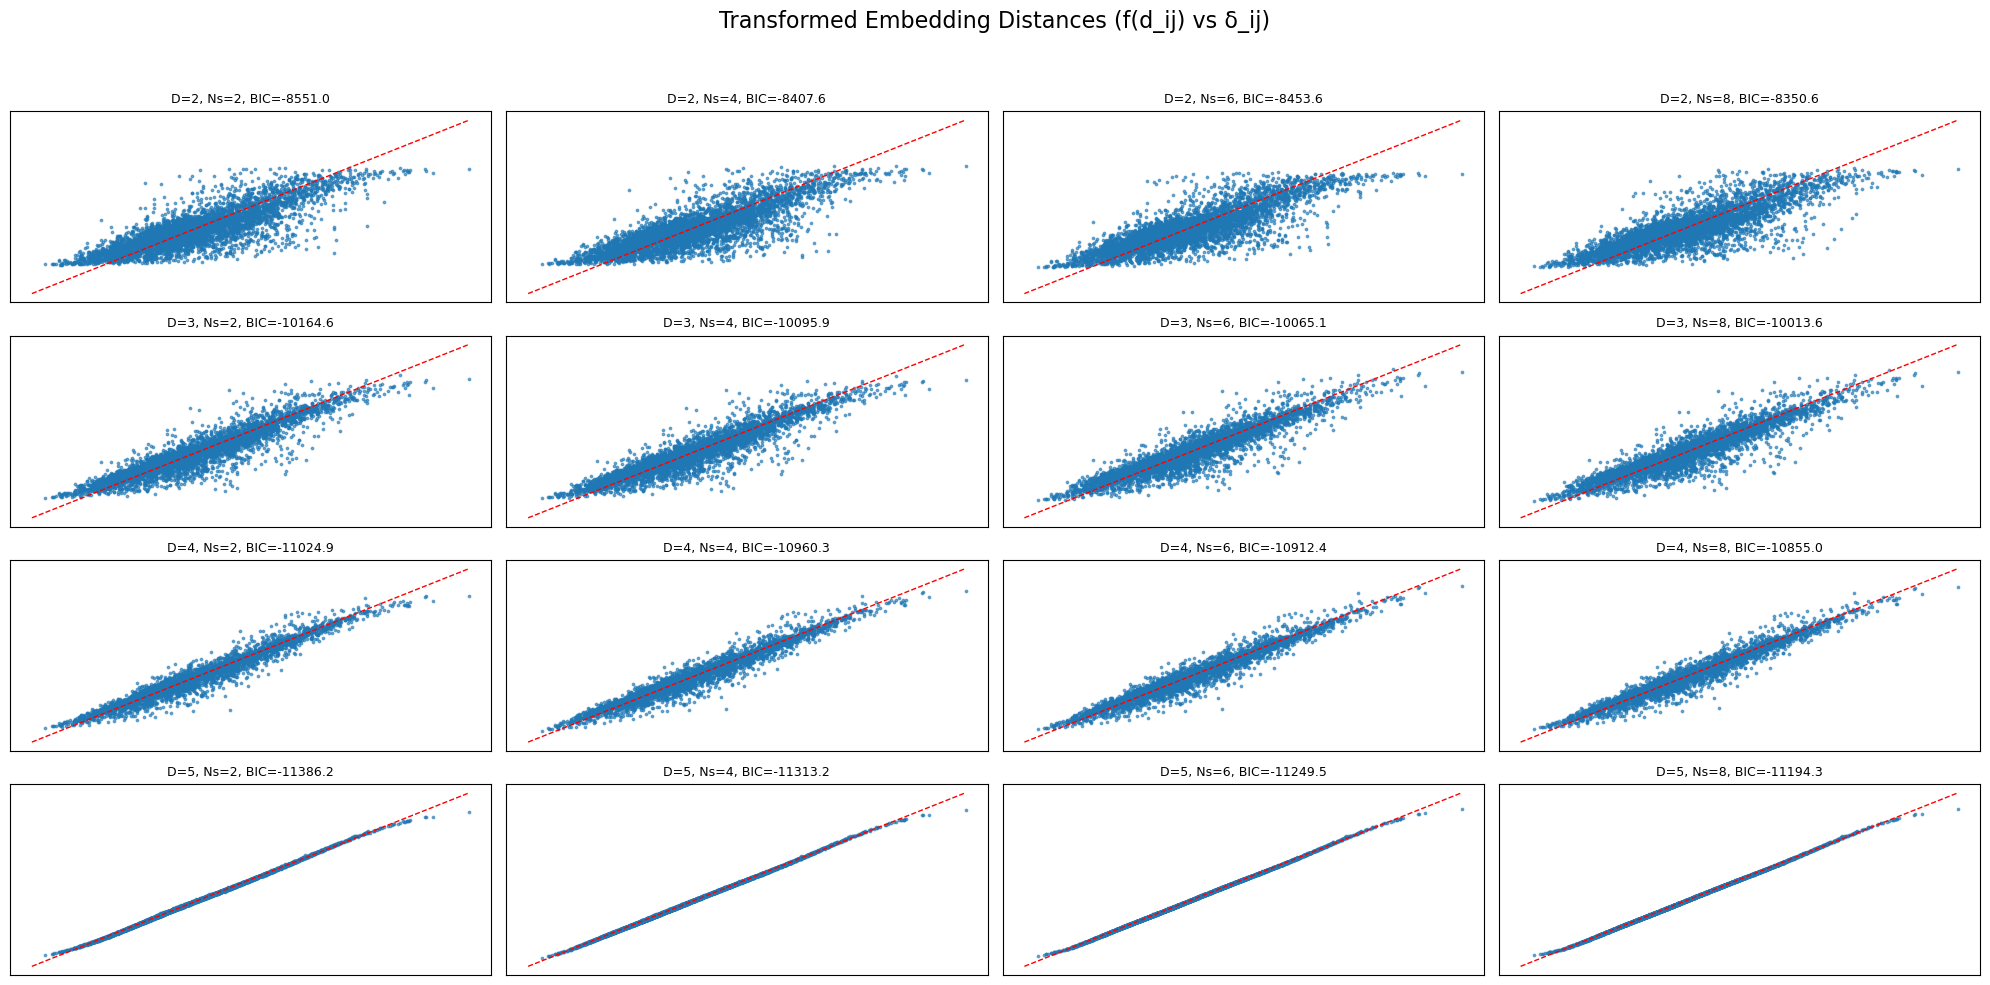

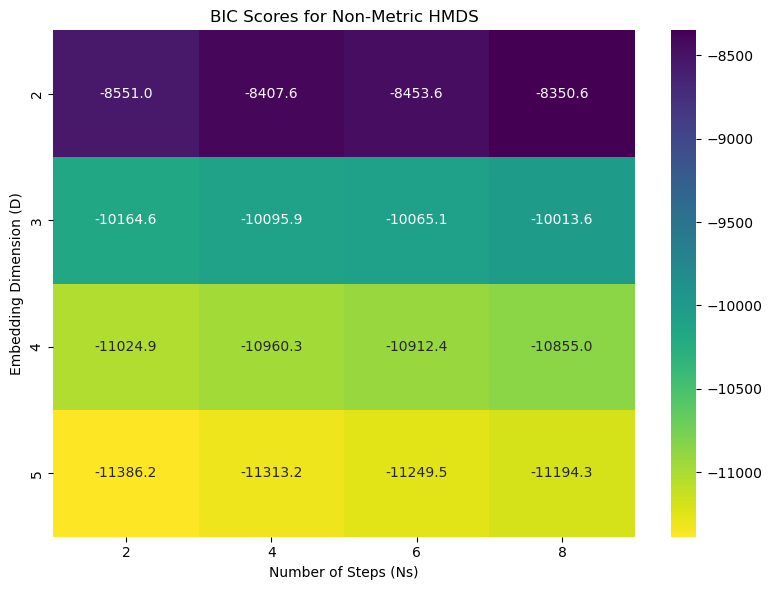

In [19]:
D_values = [2, 3, 4, 5]
Ns_values = [2, 4, 6, 8]

bic_matrix = np.zeros((len(D_values), len(Ns_values)))

# Set up subplots grid: rows = D values, cols = Ns values
fig, axs = plt.subplots(len(D_values), len(Ns_values), figsize=(20, 10))
fig.suptitle("Transformed Embedding Distances (f(d_ij) vs δ_ij)", fontsize=16)

for i, D in enumerate(D_values):
    for j, Ns in enumerate(Ns_values):
        print(f"\nTraining model with D={D}, Ns={Ns} ...")
        model = nonmetricHMDS(dmat, D=D, Ns=Ns)
        model.train(n=3000)

        # Compute BIC and store
        bic = model.BIC()
        bic_matrix[i, j] = bic
        print(f"→ BIC: {bic:.2f}")

        # Plot in corresponding subplot
        ax = axs[i, j]
        delta_flat = dmat[np.triu_indices(model.N, k=1)]
        d_trans = model.monotonic(model.pairwise_dist_lorentz()).numpy()[np.triu_indices(model.N, k=1)]

        ax.scatter(delta_flat, d_trans, s=3, alpha=0.6)
        ax.plot([0, 1], [0, 1], 'r--', lw=1)
        ax.set_title(f"D={D}, Ns={Ns}, BIC={bic:.1f}", fontsize=9)
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Now plot BIC heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(bic_matrix, annot=True, fmt=".1f", xticklabels=Ns_values, yticklabels=D_values, cmap="viridis_r")
plt.xlabel("Number of Steps (Ns)")
plt.ylabel("Embedding Dimension (D)")
plt.title("BIC Scores for Non-Metric HMDS")
plt.tight_layout()
plt.show()


This line marks the maximum distance between any two embedded points — i.e., the largest value 
𝑑
𝑖
𝑗
d 
ij
​
  in your pairwise distance matrix.

It tells you:

"My training data only contains distances up to this point."

Everything to the right of this line is extrapolation — the model is learning 
𝑓
(
𝑥
)
f(x) beyond the domain it sees.



The steps in 
𝑓
(
𝑥
)
f(x) (controlled by log_w, log_b, log_s) will move around.

In [20]:
def plot_monotonic_with_components(model):
    import matplotlib.pyplot as plt
    import numpy as np

    # Pull parameters from the model
    w = np.exp(model.log_w.numpy())
    b = np.exp(model.log_b.numpy())
    s = np.exp(model.log_s.numpy())

    # Range of x values to visualize
    maxDist = np.max(model.pairwise_dist_lorentz().numpy())
    x = np.linspace(-5, maxDist + 10, 300, dtype=np.float32)

    # Set up figure
    plt.figure(figsize=(10, 6))

    # Plot individual components: w_i * sigmoid(b_i (x - s_i))
    for i in range(len(w)):
        component = w[i] * 1 / (1 + np.exp(-4 * b[i] * (x - s[i])))
        plt.plot(x, component, '--', label=f"Step {i+1}")

    # Plot the full monotonic transform f(x)
    f_x = model.monotonic(x).numpy()
    plt.plot(x, f_x, color='black', linewidth=2, label='Total $f(x)$')

    # Mark observed distance region
    plt.vlines(maxDist, 0, model.monotonic(maxDist), linestyles='dashed', color='red')

    # Style the plot
    plt.xlabel("Input Distance $x$")
    plt.ylabel("Transformed Output $f(x)$")
    plt.title("Monotonic Transformation $f(x)$ and Step Components")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


epoch 0, Loss: 6427.06494140625, normG: 263797.125


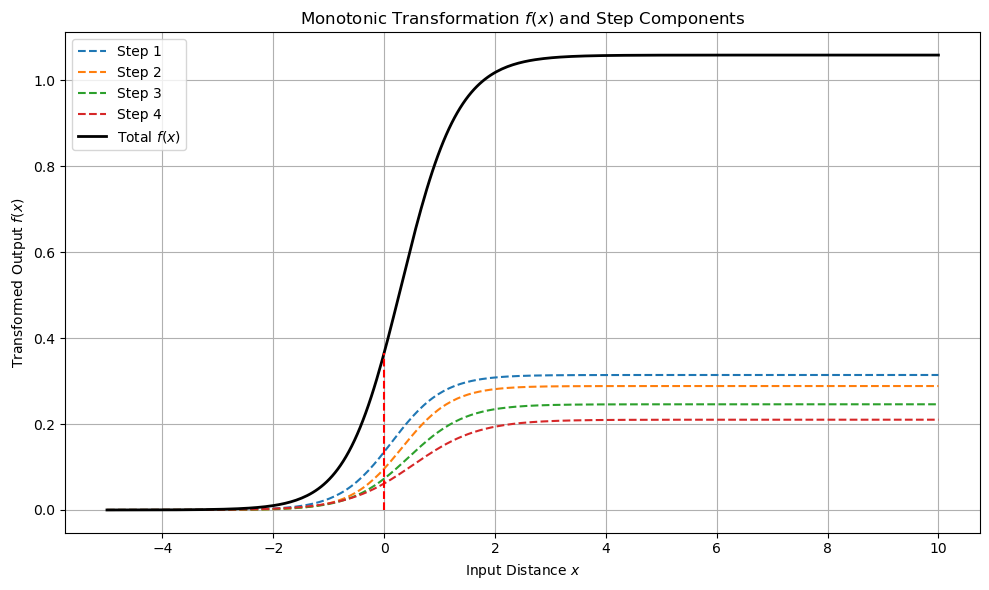

In [21]:
model = nonmetricHMDS(dmat, D=2, Ns=4)
model.train(n=3000)
plot_monotonic_with_components(model)


shouldn't the f(x) have multiple kinks or smth?

### Visualizing the Monotonic Transformation and Step Components Abhove ^

This plot shows how the learned monotonic transformation $f(x)$ is constructed from individual smooth step functions. The black curve is the total transformation:

$$
f(x) = \sum_{i=1}^{N_s} w_i \cdot \sigma(b_i (x - s_i))
$$

Each dashed colored curve represents a single step $w_i \cdot \sigma(b_i (x - s_i))$, where:

- $w_i$: weight (height of the step)  
- $b_i$: sharpness (steepness of the transition)  
- $s_i$: center (position of the step)

The **red vertical line** marks the **maximum pairwise embedding distance** — everything to the right of this line is extrapolation beyond observed data. This plot helps us understand how the model is warping distances to fit non-metric dissimilarities.


In [22]:
def plot_all_diagnostics(model):

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot 1: Loss Curve
    axes[0, 0].plot(model.loss_curve)
    axes[0, 0].set_title("Loss Curve")
    axes[0, 0].set_xlabel("Step")
    axes[0, 0].set_ylabel("Negative Log Likelihood")

    # Plot 2: Monotonic Transformation
    maxDist = np.max(model.pairwise_dist_lorentz().numpy())
    x = np.linspace(-5, maxDist + 10, 100, dtype=np.float32)
    axes[0, 1].plot(x, model.monotonic(x))
    axes[0, 1].vlines(maxDist, 0, model.monotonic(maxDist), linestyles='dashed', color='red')
    axes[0, 1].set_title("Monotonic Transformation $f(x)$")
    axes[0, 1].set_xlabel("Input Distance")
    axes[0, 1].set_ylabel("Transformed Distance")

    # Plot 3: Sigmas
    axes[1, 0].hist(np.exp(model.log_sig.numpy()), bins=15, color="steelblue", edgecolor="k")
    axes[1, 0].set_title("Uncertainty ($\\sigma_i$) Histogram")
    axes[1, 0].set_xlabel("Sigma")
    axes[1, 0].set_ylabel("Counts")

    # Plot 4: Shepard Diagram
    delta = model.deltaij.numpy()
    emb_dist = model.pairwise_dist_lorentz().numpy()
    trans_dist = model.monotonic(emb_dist).numpy()
    i, j = np.triu_indices(model.N.numpy(), k=1)

    axes[1, 1].scatter(delta[i, j], emb_dist[i, j], alpha=0.5, label="Raw Distances", color="gray")
    axes[1, 1].scatter(delta[i, j], trans_dist[i, j], alpha=0.5, label="Transformed $f(d_{ij})$", color="orange")
    axes[1, 1].plot([0, 1], [0, 1], linestyle='--', color="black")
    axes[1, 1].set_title("Shepard Diagram")
    axes[1, 1].set_xlabel("True Dissimilarity $\\delta_{ij}$")
    axes[1, 1].set_ylabel("Embedding Distance")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


epoch 0, Loss: 6427.86669921875, normG: 263831.59375


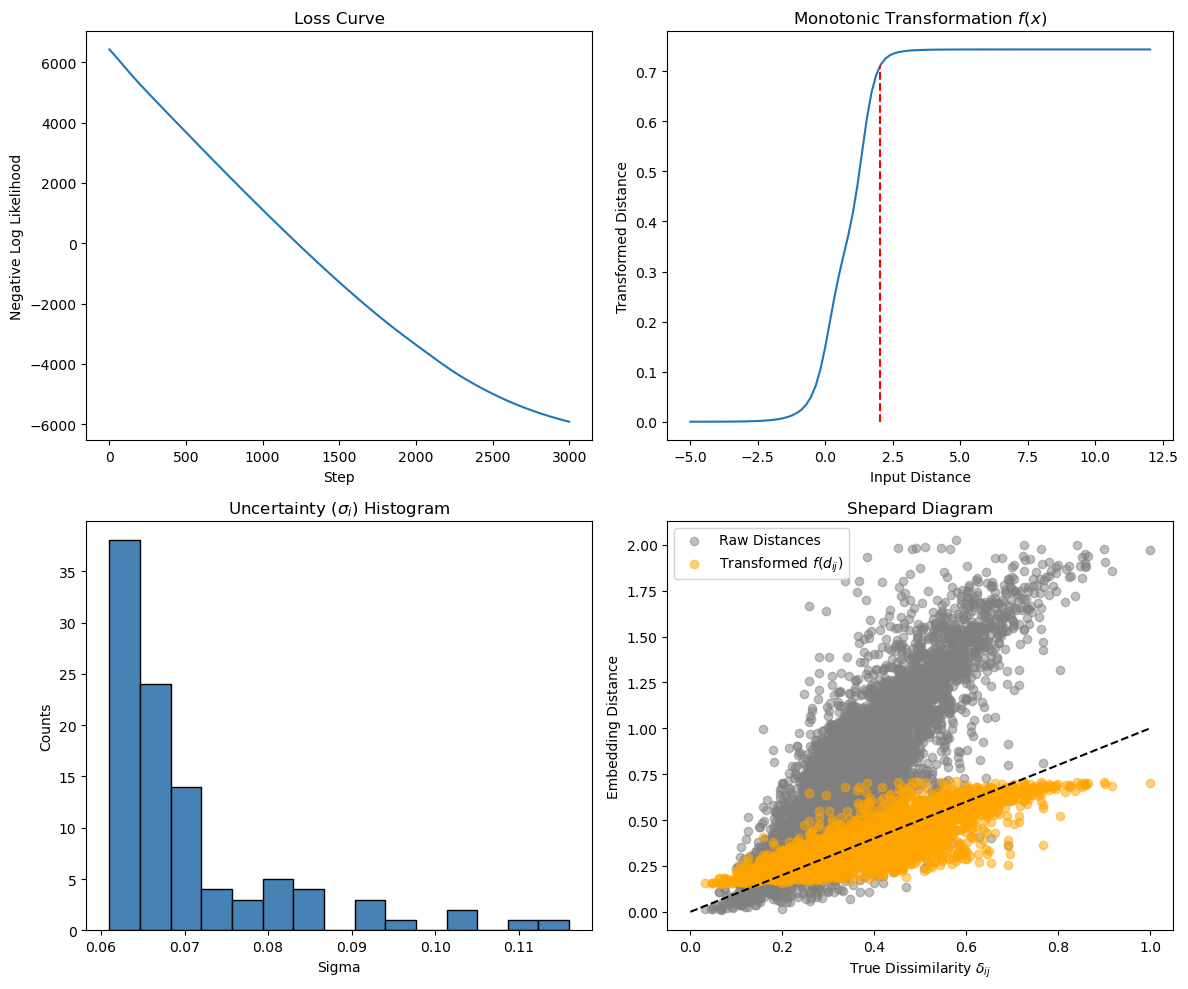

In [23]:
model = nonmetricHMDS(dmat, D=2, Ns=4)
model.train(n=3000)
plot_all_diagnostics(model)


Are we even using Spearman, Pearson, and R² between original and embedded distances?

epoch 0, Loss: 6416.16845703125, normG: 263831.53125
epoch 5000, Loss: -8439.94140625, normG: 578.7390747070312
epoch 10000, Loss: -8463.521484375, normG: 46455.84375
epoch 15000, Loss: -8479.3388671875, normG: 9.222190856933594
epoch 20000, Loss: -8494.5556640625, normG: 41.524314880371094
epoch 25000, Loss: -8509.912109375, normG: 20.36043930053711
epoch 30000, Loss: -8529.1962890625, normG: 14671.572265625
epoch 35000, Loss: -8544.3447265625, normG: 56.135459899902344
epoch 40000, Loss: -8559.3369140625, normG: 548.8981323242188
epoch 45000, Loss: -8574.328125, normG: 995.593505859375
33.18255686759949


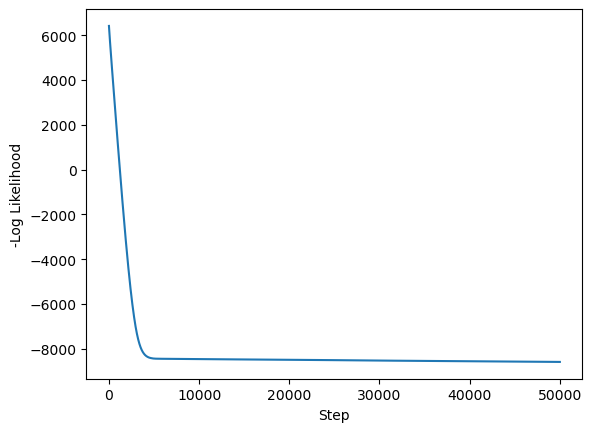

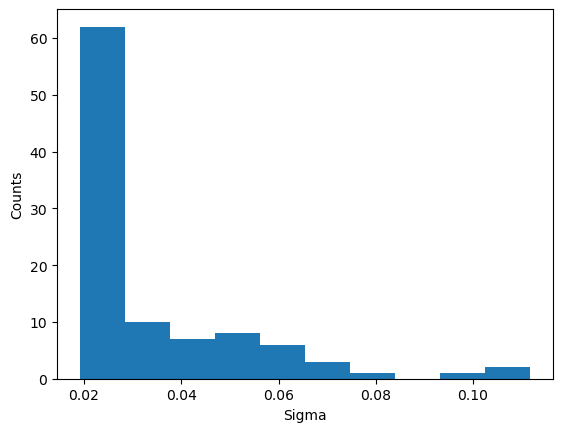

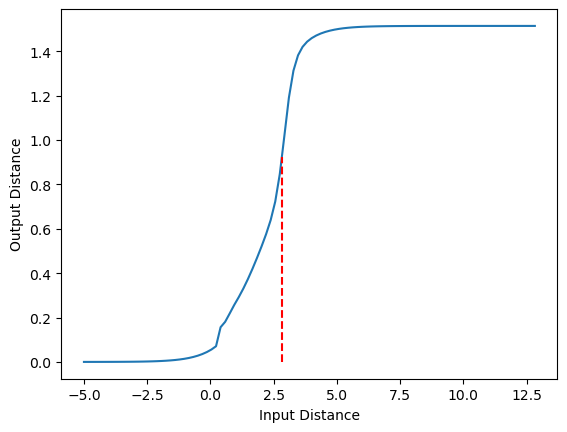

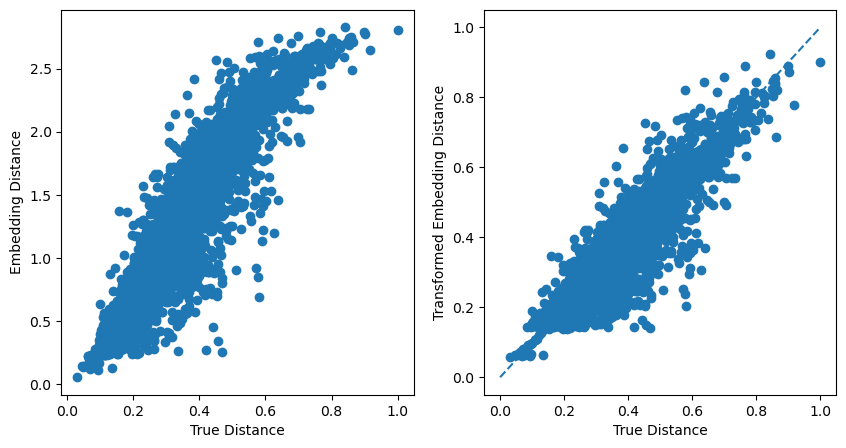

In [24]:
nmHMDS = nonmetricHMDS(dmat,3,5)
now = time.time()
nmHMDS.train(n=50000)
print(time.time() - now)
nmHMDS.plot_loss()
nmHMDS.plot_sigmas()
nmHMDS.plot_transformation()
nmHMDS.shepard()

(100, 3)


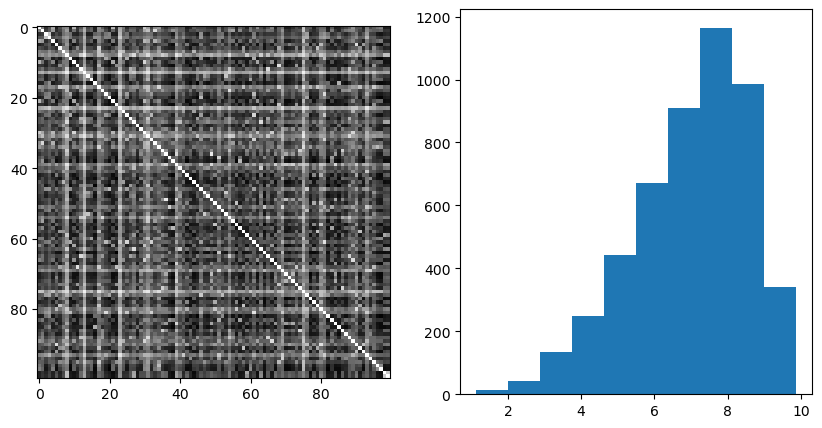

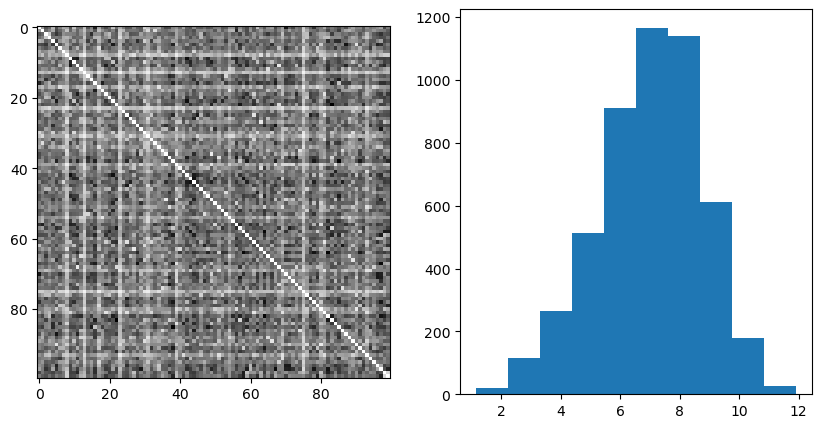

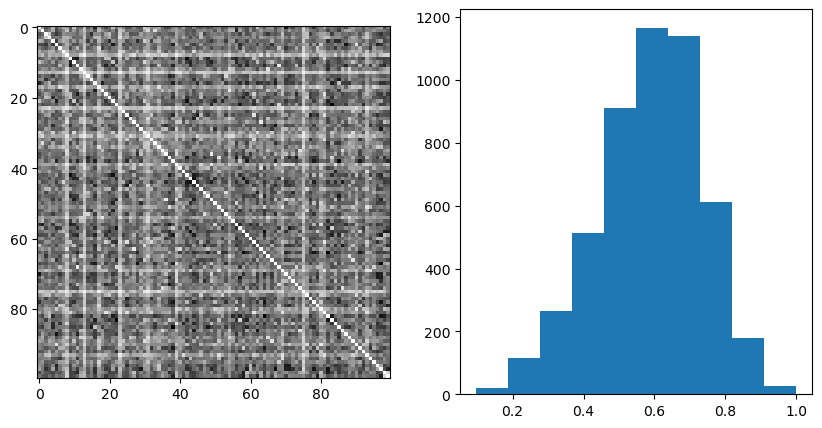

In [55]:
N = 100
pts = np.asarray([h_samp(5.0, 3) for i in np.arange(N)])
print(pts.shape)
dmat = np.zeros((N,N))

for i in np.arange(N):
    for j in np.arange(i+1, N):
        dmat[i][j] = pdist(pts[i], pts[j])
        dmat[j][i] = dmat[i][j]
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(dmat, cmap='Greys')
ax[1].hist(dmat[np.triu_indices(N,k=1)])
plt.show()

Noisy_dmat = np.zeros((N,N))
for i in np.arange(N):
    for j in np.arange(i+1, N):
        Noisy_dmat[i][j] = Noisy_dmat[j][i] = dmat[i][j]
        #if dmat[i,j] >= 6:
        Noisy_dmat[i][j] = (dmat[i][j])+np.random.normal(0,dmat[i][j]/10)
        #Noisy_dmat[i][j] = dmat[i][j] + np.random.normal(0,1/(dmat[i][j]/0.5))
        Noisy_dmat[j][i] = Noisy_dmat[i][j]

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(Noisy_dmat, cmap='Greys')
ax[1].hist(Noisy_dmat[np.triu_indices(N,k=1)])
plt.show()
        
#dmat = dmat + 0.1*np.random.normal(size=(100,100))
Noisy_dmat = Noisy_dmat/np.max(Noisy_dmat)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(Noisy_dmat, cmap='Greys')
ax[1].hist(Noisy_dmat[np.triu_indices(N,k=1)])
plt.show()

epoch 0, Loss: -5918.52880859375, normG: 46869.234375


/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_1129/1618622968.py:19: RuntimeWarning: overflow encountered in exp
  component = w[i] * 1 / (1 + np.exp(-4 * b[i] * (x - s[i])))


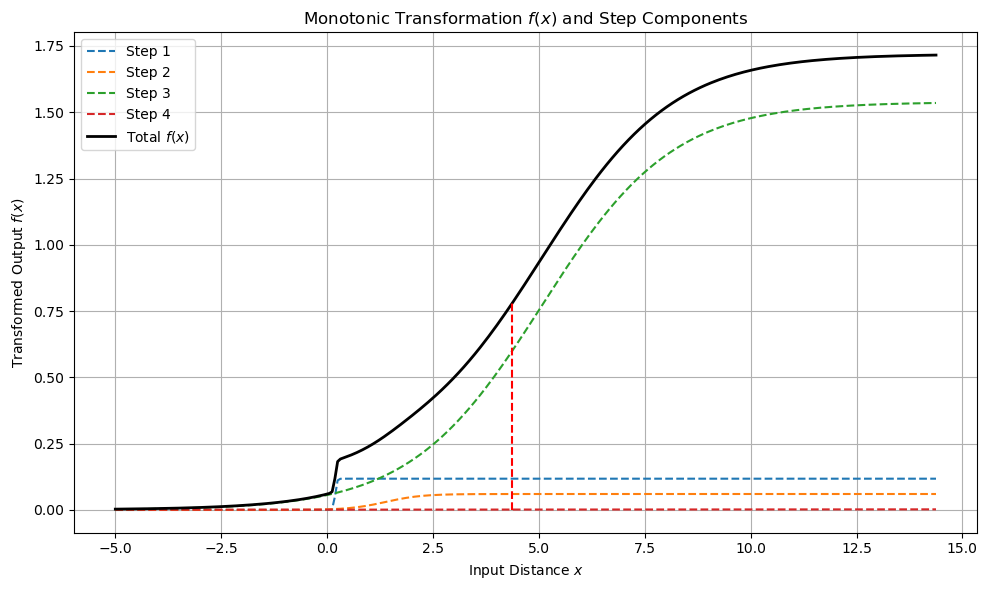

In [26]:
noisy_nm_model = nonmetricHMDS(Noisy_dmat, D=3, Ns=5)
model.train(n=3000)
plot_monotonic_with_components(model)


epoch 0, Loss: -6662.92919921875, normG: 2408.7841796875
epoch 5000, Loss: -6689.48046875, normG: 25.54507827758789
epoch 10000, Loss: -6723.48388671875, normG: 6092.2255859375
epoch 15000, Loss: -6742.63427734375, normG: 10516.9052734375
epoch 20000, Loss: -6757.6240234375, normG: 39592.25
epoch 25000, Loss: -6772.626953125, normG: 5814.40478515625


/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_1129/1618622968.py:19: RuntimeWarning: overflow encountered in exp
  component = w[i] * 1 / (1 + np.exp(-4 * b[i] * (x - s[i])))


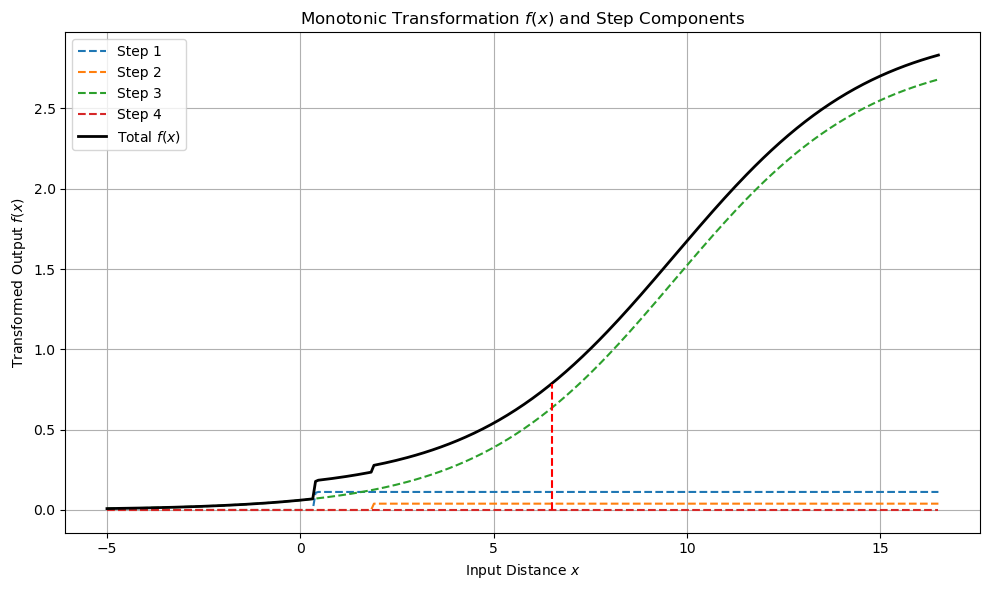

In [28]:
noisy_nm_model = nonmetricHMDS(Noisy_dmat, D=2, Ns=5)
model.train(n=30000)
plot_monotonic_with_components(model)


## RC v/s Sigma

epoch 0, Loss: 327295.125, normG: 4192889344.0
epoch 5000, Loss: 115918.75, normG: 1255209472.0


epoch 0, Loss: 322915.21875, normG: 4101194752.0
epoch 5000, Loss: 12138.90625, normG: 75230.859375


σ_rel=0.010 →  ρ_metric=0.0881,  ρ_nonmetric=0.2827
epoch 0, Loss: 327087.96875, normG: 4187911168.0
epoch 5000, Loss: 115972.9453125, normG: 1247662592.0


epoch 0, Loss: 322728.53125, normG: 4096828672.0
epoch 5000, Loss: 12196.8974609375, normG: 71292.78125


σ_rel=0.045 →  ρ_metric=0.0623,  ρ_nonmetric=0.6058
epoch 0, Loss: 327134.65625, normG: 4188177152.0
epoch 5000, Loss: 116128.6875, normG: 1240596096.0


epoch 0, Loss: 322996.28125, normG: 4102876672.0
epoch 5000, Loss: 12262.4326171875, normG: 68861.1015625


σ_rel=0.081 →  ρ_metric=0.0481,  ρ_nonmetric=0.1085
epoch 0, Loss: 328480.78125, normG: 4225506816.0
epoch 5000, Loss: 116529.3203125, normG: 1254245760.0


epoch 0, Loss: 324223.1875, normG: 4136610304.0
epoch 5000, Loss: 12339.955078125, normG: 60547.03125


σ_rel=0.116 →  ρ_metric=0.0475,  ρ_nonmetric=0.1980
epoch 0, Loss: 327967.53125, normG: 4208304896.0
epoch 5000, Loss: 116327.1328125, normG: 1250633728.0


epoch 0, Loss: 323624.59375, normG: 4117338624.0
epoch 5000, Loss: 12493.736328125, normG: 53688.8984375


σ_rel=0.152 →  ρ_metric=0.0635,  ρ_nonmetric=0.2587
epoch 0, Loss: 328772.0, normG: 4230746624.0
epoch 5000, Loss: 116713.609375, normG: 1250782208.0


epoch 0, Loss: 324454.4375, normG: 4140124928.0
epoch 5000, Loss: 12649.173828125, normG: 44370.0546875


σ_rel=0.187 →  ρ_metric=0.0451,  ρ_nonmetric=0.2651
epoch 0, Loss: 330996.375, normG: 4292989952.0
epoch 5000, Loss: 117507.8125, normG: 1266086912.0


epoch 0, Loss: 326738.96875, normG: 4203241728.0
epoch 5000, Loss: 12877.826171875, normG: 32276.37890625


σ_rel=0.223 →  ρ_metric=0.0681,  ρ_nonmetric=0.1360
epoch 0, Loss: 330592.125, normG: 4284900352.0
epoch 5000, Loss: 117277.1015625, normG: 1268105984.0


epoch 0, Loss: 326381.71875, normG: 4196473088.0
epoch 5000, Loss: 13128.9208984375, normG: 25157.4296875


σ_rel=0.258 →  ρ_metric=0.1195,  ρ_nonmetric=0.5453
epoch 0, Loss: 330070.25, normG: 4268910080.0
epoch 5000, Loss: 117345.8125, normG: 1250569984.0


epoch 0, Loss: 325826.03125, normG: 4179634432.0
epoch 5000, Loss: 13329.6826171875, normG: 18562.34765625


σ_rel=0.294 →  ρ_metric=0.0657,  ρ_nonmetric=0.5644
epoch 0, Loss: 334635.96875, normG: 4391887360.0
epoch 5000, Loss: 119141.2890625, normG: 1273996672.0


epoch 0, Loss: 330398.28125, normG: 4301416960.0
epoch 5000, Loss: 13552.875, normG: 13825.2080078125


σ_rel=0.329 →  ρ_metric=0.0390,  ρ_nonmetric=0.2094
epoch 0, Loss: 336264.90625, normG: 4440043008.0
epoch 5000, Loss: 119688.1875, normG: 1286562048.0


epoch 0, Loss: 331990.53125, normG: 4347478528.0
epoch 5000, Loss: 13897.525390625, normG: 11823.5927734375


σ_rel=0.365 →  ρ_metric=0.0730,  ρ_nonmetric=0.2762
epoch 0, Loss: 335917.8125, normG: 4425060864.0
epoch 5000, Loss: 119835.1640625, normG: 1270369920.0


epoch 0, Loss: 331575.71875, normG: 4331162112.0
epoch 5000, Loss: 14103.1474609375, normG: 11296.162109375
σ_rel=0.400 →  ρ_metric=0.0310,  ρ_nonmetric=0.5896


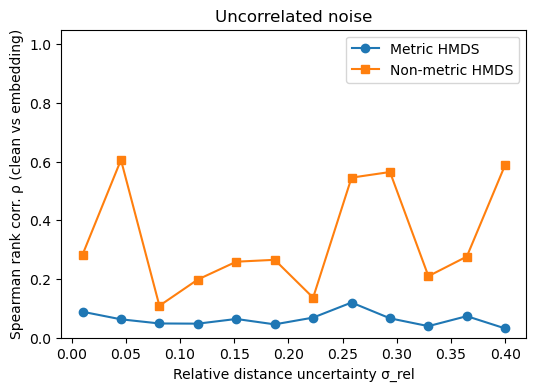

In [45]:

# ---------------------------------------------------------
# 1.  Clean hyperbolic point cloud and distance matrix
# ---------------------------------------------------------
N    = 100
K    = -1.0                    # curvature |K|=1  ⇒ radius≈1
Rmax = 5.0                     # radial cut‑off used in h_samp
D    = 3                       # embed‑dimension
Ns = 5

pts  = np.asarray([h_samp(Rmax, D) for _ in range(N)])
dmat = np.zeros((N, N), dtype=np.float32)

for i in range(N):
    for j in range(i + 1, N):
        dij = pdist(pts[i], pts[j]).numpy() if tf.is_tensor(pts[i]) else pdist(pts[i], pts[j])
        dmat[i, j] = dmat[j, i] = dij

# ---------------------------------------------------------
# 2.  Helper: build a noisy distance matrix for a given σ_rel
# ---------------------------------------------------------
def make_noisy_dmat(dmat, sigma_rel, sin_amp=10.0):
    """
    Parameters
    ----------
    dmat : (N,N) ndarray – clean hyperbolic distances
    sigma_rel : float      – multiplicative noise level (e.g. 0.05 ⇒ 5 % std)
    sin_amp : float        – amplitude of the sin non‑linearity you wanted

    Returns
    -------
    Noisy_dmat : (N,N) ndarray (symmetric, diag=0)
    """
    N = dmat.shape[0]
    Nd = np.zeros_like(dmat, dtype=np.float32)

    for i in range(N):
        for j in range(i + 1, N):
            base = dmat[i, j]
            nonlinear = sin_amp * np.sin(np.pi * base / 20.0)  # monotonic distorter
            noisy = base + nonlinear + np.random.normal(0.0, sigma_rel * base)
            Nd[i, j] = Nd[j, i] = noisy

    return Nd

# ---------------------------------------------------------
# 3.  Experimental sweep over uncertainty levels
# ---------------------------------------------------------
rel_sigmas = np.linspace(0.01, 0.40, 12)          # 1 % … 40 % noise
rho_metric, rho_nonmetric = [], []

for s in rel_sigmas:
    Noisy = make_noisy_dmat(dmat, sigma_rel=s)

    # ---- Metric HMDS -------------------------------------------------------
    hm = HMDS(Noisy, D=D)
    hm.train(10_000)                         # adjust / early‑stop as needed

    # Pairwise distances from the learned embedding (tensor → numpy)
    d_emb_hm = hm.pairwise_dist_lorentz().numpy()

    # ---- Non‑metric HMDS ----------------------------------------------------
    nm = nonmetricHMDS(Noisy, D=D, Ns = Ns)
    nm.train(10_000)

    d_emb_nm = nm.pairwise_dist_lorentz().numpy()  # g(·) is monotone ⇒ rank unchanged

    # ---- Rank correlations --------------------------------------------------
    iu = np.triu_indices(N, k=1)                   # upper‑triangle indices

    rho_hm, _ = spearmanr(dmat[iu], d_emb_hm[iu])
    rho_nm, _ = spearmanr(dmat[iu], d_emb_nm[iu])

    rho_metric.append(rho_hm)
    rho_nonmetric.append(rho_nm)

    print(f"σ_rel={s:0.3f} →  ρ_metric={rho_hm:0.4f},  ρ_nonmetric={rho_nm:0.4f}")

# ---------------------------------------------------------
# 4.  Plot
# ---------------------------------------------------------

plt.figure(figsize=(6,4))
plt.plot(rel_sigmas, rho_metric,    marker='o', label='Metric HMDS')
plt.plot(rel_sigmas, rho_nonmetric, marker='s', label='Non‑metric HMDS')
plt.xlabel('Relative distance uncertainty σ_rel')
plt.ylabel("Spearman rank corr. ρ (clean vs embedding)")
plt.ylim(0, 1.05)
plt.legend()
plt.title('Uncorrelated noise')
plt.show()


In [42]:
def make_correlated_noisy_dmat(dmat,
                               rel_sigma_min=0.02,
                               rel_sigma_max=0.40,
                               sin_amp=10.0):
    """
    Add *correlated* noise:   σ_ij  grows linearly from
    rel_sigma_min·d_ij  at the smallest distances to
    rel_sigma_max·d_ij  at the largest distances.

    Parameters
    ----------
    dmat : ndarray (N,N)
        Clean hyperbolic distances.
    rel_sigma_min, rel_sigma_max : float
        Lowest / highest *relative* noise levels across the matrix.
    sin_amp : float
        Amplitude of the monotonic sin() warp you already like to inject.

    Returns
    -------
    Nd : ndarray (N,N)
        Symmetric noisy distance matrix (diag = 0).
    """
    N          = dmat.shape[0]
    Nd         = np.zeros_like(dmat, dtype=np.float32)

    # Pre‑compute global min / max of the *upper* triangle (excluding zeros)
    iu         = np.triu_indices(N, k=1)
    d_min      = dmat[iu].min()
    d_max      = dmat[iu].max()
    span_inv   = 1.0 / (d_max - d_min)          # cached for speed

    for i in range(N):
        for j in range(i + 1, N):
            base   = dmat[i, j]

            # ---------- distance‑dependent std‑dev -------------------------
            # Linear ramp from rel_sigma_min to rel_sigma_max
            rel_sigma = rel_sigma_min + (rel_sigma_max - rel_sigma_min) * (
                         (base - d_min) * span_inv )
            std       = rel_sigma * base          # σ_ij  ∝  d_ij

            # ---------- add the noise & monotonic warp ---------------------
            nonlinear = sin_amp * np.sin(np.pi * base / 20.0)
            noisy     = base + nonlinear + np.random.normal(0.0, std)

            Nd[i, j] = Nd[j, i] = noisy

    return Nd


epoch 0, Loss: 326379.90625, normG: 4098414592.0
epoch 5000, Loss: 115475.96875, normG: 1246062080.0


epoch 0, Loss: 322140.8125, normG: 4012024064.0
epoch 5000, Loss: 11707.876953125, normG: 63989.58984375


σ_rel=0.010 →  ρ_metric=0.0728,  ρ_nonmetric=0.6692
epoch 0, Loss: 326734.0, normG: 4107706624.0
epoch 5000, Loss: 115572.0625, normG: 1249620992.0


epoch 0, Loss: 322439.6875, normG: 4019833856.0
epoch 5000, Loss: 11705.6787109375, normG: 64528.97265625


σ_rel=0.045 →  ρ_metric=0.0214,  ρ_nonmetric=0.6269
epoch 0, Loss: 327157.75, normG: 4119087104.0
epoch 5000, Loss: 115785.3671875, normG: 1249753856.0


epoch 0, Loss: 322831.3125, normG: 4030252800.0
epoch 5000, Loss: 11775.34375, normG: 60002.140625


σ_rel=0.081 →  ρ_metric=0.0757,  ρ_nonmetric=0.7708
epoch 0, Loss: 326584.21875, normG: 4104922624.0
epoch 5000, Loss: 115588.515625, normG: 1245471360.0


epoch 0, Loss: 322232.9375, normG: 4015589632.0
epoch 5000, Loss: 11809.2490234375, normG: 58014.52734375


σ_rel=0.116 →  ρ_metric=0.0375,  ρ_nonmetric=0.6887
epoch 0, Loss: 327919.84375, normG: 4140698624.0
epoch 5000, Loss: 116180.4296875, normG: 1249288960.0


epoch 0, Loss: 323596.3125, normG: 4051325952.0
epoch 5000, Loss: 11952.802734375, normG: 49184.58984375


σ_rel=0.152 →  ρ_metric=0.0812,  ρ_nonmetric=0.6568
epoch 0, Loss: 327809.34375, normG: 4138064640.0
epoch 5000, Loss: 116131.3203125, normG: 1247783168.0


epoch 0, Loss: 323594.125, normG: 4051473408.0
epoch 5000, Loss: 11990.2705078125, normG: 47345.49609375


σ_rel=0.187 →  ρ_metric=0.0335,  ρ_nonmetric=0.7139
epoch 0, Loss: 329192.40625, normG: 4175625216.0
epoch 5000, Loss: 116812.109375, normG: 1248716032.0


epoch 0, Loss: 324840.90625, normG: 4085373440.0
epoch 5000, Loss: 12186.7763671875, normG: 36888.35546875


σ_rel=0.223 →  ρ_metric=0.0323,  ρ_nonmetric=0.3997
epoch 0, Loss: 328700.0625, normG: 4164701184.0
epoch 5000, Loss: 116462.3984375, normG: 1254016896.0


epoch 0, Loss: 324497.53125, normG: 4078411008.0
epoch 5000, Loss: 12324.4072265625, normG: 31151.451171875


σ_rel=0.258 →  ρ_metric=0.0577,  ρ_nonmetric=0.5975
epoch 0, Loss: 330952.5, normG: 4224458752.0
epoch 5000, Loss: 117476.9140625, normG: 1258124928.0


epoch 0, Loss: 326790.0, normG: 4138520320.0
epoch 5000, Loss: 12427.5185546875, normG: 28660.599609375


σ_rel=0.294 →  ρ_metric=0.0305,  ρ_nonmetric=0.8714
epoch 0, Loss: 329847.0, normG: 4196219136.0
epoch 5000, Loss: 116985.0546875, normG: 1256597760.0


epoch 0, Loss: 325558.375, normG: 4107296000.0
epoch 5000, Loss: 12677.2236328125, normG: 18761.130859375


σ_rel=0.329 →  ρ_metric=0.0699,  ρ_nonmetric=0.6418
epoch 0, Loss: 330472.21875, normG: 4211872000.0
epoch 5000, Loss: 117314.1484375, normG: 1254761984.0


epoch 0, Loss: 326239.53125, normG: 4124136704.0
epoch 5000, Loss: 12851.09765625, normG: 14455.294921875


σ_rel=0.365 →  ρ_metric=0.0445,  ρ_nonmetric=0.6004
epoch 0, Loss: 329630.21875, normG: 4189265920.0
epoch 5000, Loss: 116998.8984375, normG: 1249134464.0


epoch 0, Loss: 325725.875, normG: 4110296576.0
epoch 5000, Loss: 12744.22265625, normG: 21063.9375
σ_rel=0.400 →  ρ_metric=0.0471,  ρ_nonmetric=0.8962


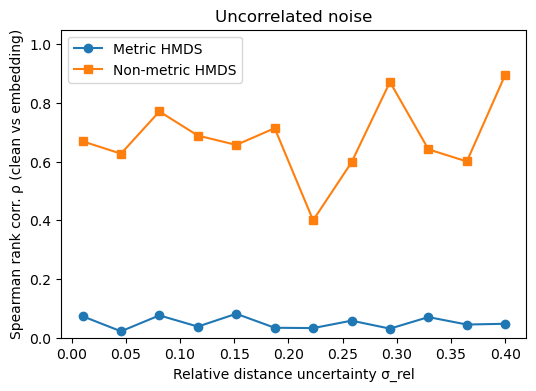

In [44]:

# ---------------------------------------------------------
# 3.  Experimental sweep over uncertainty levels
# ---------------------------------------------------------
rel_sigmas = np.linspace(0.01, 0.40, 12)          # 1 % … 40 % noise
rho_metric, rho_nonmetric = [], []

for s in rel_sigmas:
    Noisy = make_correlated_noisy_dmat(dmat,
                                   rel_sigma_min=0.02,
                                   rel_sigma_max=s)   # `s` from rel_sigmas sweep


    # ---- Metric HMDS -------------------------------------------------------
    hm = HMDS(Noisy, D=D)
    hm.train(10_000)                         # adjust / early‑stop as needed

    # Pairwise distances from the learned embedding (tensor → numpy)
    d_emb_hm = hm.pairwise_dist_lorentz().numpy()

    # ---- Non‑metric HMDS ----------------------------------------------------
    nm = nonmetricHMDS(Noisy, D=D, Ns = Ns)
    nm.train(10_000)

    d_emb_nm = nm.pairwise_dist_lorentz().numpy()  # g(·) is monotone ⇒ rank unchanged

    # ---- Rank correlations --------------------------------------------------
    iu = np.triu_indices(N, k=1)                   # upper‑triangle indices

    rho_hm, _ = spearmanr(dmat[iu], d_emb_hm[iu])
    rho_nm, _ = spearmanr(dmat[iu], d_emb_nm[iu])

    rho_metric.append(rho_hm)
    rho_nonmetric.append(rho_nm)

    print(f"σ_rel={s:0.3f} →  ρ_metric={rho_hm:0.4f},  ρ_nonmetric={rho_nm:0.4f}")

# ---------------------------------------------------------
# 4.  Plot
# ---------------------------------------------------------

plt.figure(figsize=(6,4))
plt.plot(rel_sigmas, rho_metric,    marker='o', label='Metric HMDS')
plt.plot(rel_sigmas, rho_nonmetric, marker='s', label='Non‑metric HMDS')
plt.xlabel('Relative distance uncertainty σ_rel')
plt.ylabel("Spearman rank corr. ρ (clean vs embedding)")
plt.ylim(0, 1.05)
plt.legend()
plt.title('Uncorrelated noise')
plt.show()


epoch 0, Loss: 7005.4365234375, normG: 160833.375
epoch 5000, Loss: -5743.59228515625, normG: 4682.1416015625
epoch 0, Loss: 6793.63916015625, normG: 218457.8125
epoch 5000, Loss: -10114.3466796875, normG: 6745.87646484375
σ_rel=0.010 →  ρ_metric=0.9754,  ρ_nonmetric=0.9961
epoch 0, Loss: 7010.59912109375, normG: 160136.859375
epoch 5000, Loss: -5057.0849609375, normG: 2249.797607421875
epoch 0, Loss: 6797.181640625, normG: 217842.671875
epoch 5000, Loss: -6787.05419921875, normG: 516.3991088867188
σ_rel=0.045 →  ρ_metric=0.9746,  ρ_nonmetric=0.9561
epoch 0, Loss: 7015.6220703125, normG: 159278.765625
epoch 5000, Loss: -3983.2587890625, normG: 779.3687744140625
epoch 0, Loss: 6802.60498046875, normG: 216933.015625
epoch 5000, Loss: -5136.32421875, normG: 188.61669921875
σ_rel=0.081 →  ρ_metric=0.9663,  ρ_nonmetric=0.9504
epoch 0, Loss: 7017.638671875, normG: 159021.5
epoch 5000, Loss: -2799.52197265625, normG: 367.0563659667969
epoch 0, Loss: 6806.2431640625, normG: 216152.328125
epoch

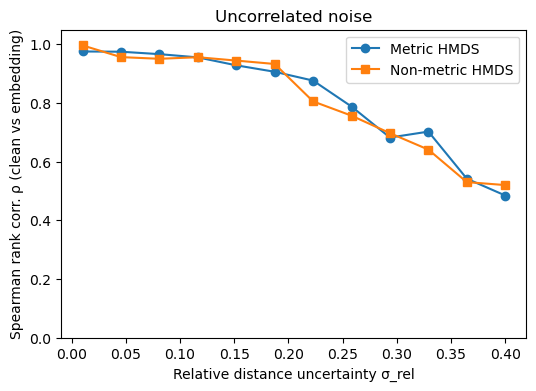

In [57]:

# ---------------------------------------------------------
# 1.  Clean hyperbolic point cloud and distance matrix
# ---------------------------------------------------------
N    = 100
K    = -1.0                    # curvature |K|=1  ⇒ radius≈1
Rmax = 5.0                     # radial cut‑off used in h_samp
D    = 3                       # embed‑dimension
Ns = 5

pts  = np.asarray([h_samp(Rmax, D) for _ in range(N)])
dmat = np.zeros((N, N), dtype=np.float32)

for i in range(N):
    for j in range(i + 1, N):
        dij = pdist(pts[i], pts[j]).numpy() if tf.is_tensor(pts[i]) else pdist(pts[i], pts[j])
        dmat[i, j] = dmat[j, i] = dij

dmat = dmat/np.max(dmat)

# ---------------------------------------------------------
# 2.  Helper: build a noisy distance matrix for a given σ_rel
# ---------------------------------------------------------
def make_noisy_dmat(dmat, sigma_rel, sin_amp=10.0):
    """
    Parameters
    ----------
    dmat : (N,N) ndarray – clean hyperbolic distances
    sigma_rel : float      – multiplicative noise level (e.g. 0.05 ⇒ 5 % std)
    sin_amp : float        – amplitude of the sin non‑linearity you wanted

    Returns
    -------
    Noisy_dmat : (N,N) ndarray (symmetric, diag=0)
    """
    N = dmat.shape[0]
    Nd = np.zeros_like(dmat, dtype=np.float32)

    for i in range(N):
        for j in range(i + 1, N):
            base = dmat[i, j]
            nonlinear = sin_amp * np.sin(np.pi * base / 20.0)  # monotonic distorter
            noisy = base + np.random.normal(0.0, sigma_rel)
            Nd[i, j] = Nd[j, i] = noisy

    return Nd

# ---------------------------------------------------------
# 3.  Experimental sweep over uncertainty levels
# ---------------------------------------------------------
rel_sigmas = np.linspace(0.01, 0.40, 12)          # 1 % … 40 % noise
rho_metric, rho_nonmetric = [], []

for s in rel_sigmas:
    Noisy = make_noisy_dmat(dmat, sigma_rel=s)

    # ---- Metric HMDS -------------------------------------------------------
    hm = HMDS(Noisy, D=D)
    hm.train(10_000)                         # adjust / early‑stop as needed

    # Pairwise distances from the learned embedding (tensor → numpy)
    d_emb_hm = hm.pairwise_dist_lorentz().numpy()

    # ---- Non‑metric HMDS ----------------------------------------------------
    nm = nonmetricHMDS(Noisy, D=D, Ns = Ns)
    nm.train(10_000)

    d_emb_nm = nm.pairwise_dist_lorentz().numpy()  # g(·) is monotone ⇒ rank unchanged

    # ---- Rank correlations --------------------------------------------------
    iu = np.triu_indices(N, k=1)                   # upper‑triangle indices

    rho_hm, _ = spearmanr(dmat[iu], d_emb_hm[iu])
    rho_nm, _ = spearmanr(dmat[iu], d_emb_nm[iu])

    rho_metric.append(rho_hm)
    rho_nonmetric.append(rho_nm)

    print(f"σ_rel={s:0.3f} →  ρ_metric={rho_hm:0.4f},  ρ_nonmetric={rho_nm:0.4f}")

# ---------------------------------------------------------
# 4.  Plot
# ---------------------------------------------------------

plt.figure(figsize=(6,4))
plt.plot(rel_sigmas, rho_metric,    marker='o', label='Metric HMDS')
plt.plot(rel_sigmas, rho_nonmetric, marker='s', label='Non‑metric HMDS')
plt.xlabel('Relative distance uncertainty σ_rel')
plt.ylabel("Spearman rank corr. ρ (clean vs embedding)")
plt.ylim(0, 1.05)
plt.legend()
plt.title('Uncorrelated noise')
plt.show()


epoch 0, Loss: 7022.640625, normG: 159175.28125
epoch 5000, Loss: -5672.89208984375, normG: 4783.744140625
epoch 0, Loss: 6808.939453125, normG: 216969.5
epoch 5000, Loss: -10202.880859375, normG: 443741.25
σ_rel=0.010 →  ρ_metric=0.9744,  ρ_nonmetric=0.9968
epoch 0, Loss: 6894.048828125, normG: 178746.34375
epoch 5000, Loss: -5620.599609375, normG: 2617.8671875
epoch 0, Loss: 6697.90087890625, normG: 228974.78125
epoch 5000, Loss: -8704.1455078125, normG: 1087.854736328125
σ_rel=0.045 →  ρ_metric=0.9731,  ρ_nonmetric=0.9943
epoch 0, Loss: 6805.68310546875, normG: 193810.828125
epoch 5000, Loss: -5244.34716796875, normG: 1374.8411865234375
epoch 0, Loss: 6624.20654296875, normG: 237599.53125
epoch 5000, Loss: -6932.88134765625, normG: 359.48468017578125
σ_rel=0.081 →  ρ_metric=0.9684,  ρ_nonmetric=0.9499
epoch 0, Loss: 6748.666015625, normG: 203651.46875
epoch 5000, Loss: -4676.705078125, normG: 464.5908508300781
epoch 0, Loss: 6578.5537109375, normG: 243053.3125
epoch 5000, Loss: -646

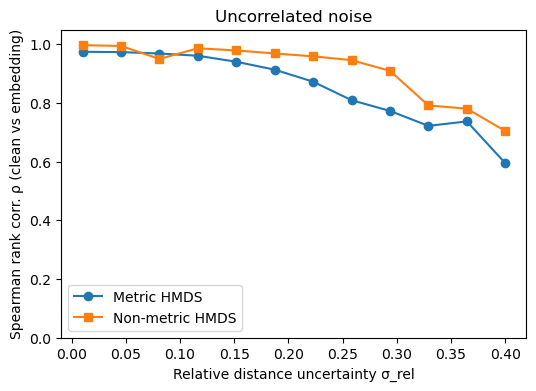

In [58]:

# ---------------------------------------------------------
# 1.  Clean hyperbolic point cloud and distance matrix
# ---------------------------------------------------------
N    = 100
K    = -1.0                    # curvature |K|=1  ⇒ radius≈1
Rmax = 5.0                     # radial cut‑off used in h_samp
D    = 3                       # embed‑dimension
Ns = 5

pts  = np.asarray([h_samp(Rmax, D) for _ in range(N)])
dmat = np.zeros((N, N), dtype=np.float32)

for i in range(N):
    for j in range(i + 1, N):
        dij = pdist(pts[i], pts[j]).numpy() if tf.is_tensor(pts[i]) else pdist(pts[i], pts[j])
        dmat[i, j] = dmat[j, i] = dij

dmat = dmat/np.max(dmat)

# ---------------------------------------------------------
# 2.  Helper: build a noisy distance matrix for a given σ_rel
# ---------------------------------------------------------
def make_noisy_dmat(dmat, sigma_rel, sin_amp=10.0):
    """
    Parameters
    ----------
    dmat : (N,N) ndarray – clean hyperbolic distances
    sigma_rel : float      – multiplicative noise level (e.g. 0.05 ⇒ 5 % std)
    sin_amp : float        – amplitude of the sin non‑linearity you wanted

    Returns
    -------
    Noisy_dmat : (N,N) ndarray (symmetric, diag=0)
    """
    N = dmat.shape[0]
    Nd = np.zeros_like(dmat, dtype=np.float32)

    for i in range(N):
        for j in range(i + 1, N):
            base = dmat[i, j]
            nonlinear = sin_amp * np.sin(np.pi * base / 20.0)  # monotonic distorter
            noisy = base + np.random.normal(0.0, sigma_rel*base)
            Nd[i, j] = Nd[j, i] = noisy

    Nd = Nd/np.max(Nd)

    return Nd

# ---------------------------------------------------------
# 3.  Experimental sweep over uncertainty levels
# ---------------------------------------------------------
rel_sigmas = np.linspace(0.01, 0.40, 12)          # 1 % … 40 % noise
rho_metric, rho_nonmetric = [], []

for s in rel_sigmas:
    Noisy = make_noisy_dmat(dmat, sigma_rel=s)

    # ---- Metric HMDS -------------------------------------------------------
    hm = HMDS(Noisy, D=D)
    hm.train(10_000)                         # adjust / early‑stop as needed

    # Pairwise distances from the learned embedding (tensor → numpy)
    d_emb_hm = hm.pairwise_dist_lorentz().numpy()

    # ---- Non‑metric HMDS ----------------------------------------------------
    nm = nonmetricHMDS(Noisy, D=D, Ns = Ns)
    nm.train(10_000)

    d_emb_nm = nm.pairwise_dist_lorentz().numpy()  # g(·) is monotone ⇒ rank unchanged

    # ---- Rank correlations --------------------------------------------------
    iu = np.triu_indices(N, k=1)                   # upper‑triangle indices

    rho_hm, _ = spearmanr(dmat[iu], d_emb_hm[iu])
    rho_nm, _ = spearmanr(dmat[iu], d_emb_nm[iu])

    rho_metric.append(rho_hm)
    rho_nonmetric.append(rho_nm)

    print(f"σ_rel={s:0.3f} →  ρ_metric={rho_hm:0.4f},  ρ_nonmetric={rho_nm:0.4f}")

# ---------------------------------------------------------
# 4.  Plot
# ---------------------------------------------------------

plt.figure(figsize=(6,4))
plt.plot(rel_sigmas, rho_metric,    marker='o', label='Metric HMDS')
plt.plot(rel_sigmas, rho_nonmetric, marker='s', label='Non‑metric HMDS')
plt.xlabel('Relative distance uncertainty σ_rel')
plt.ylabel("Spearman rank corr. ρ (clean vs embedding)")
plt.ylim(0, 1.05)
plt.legend()
plt.title('CO-rrelated noise')
plt.show()


epoch 0, Loss: 6528.6552734375, normG: 244699.21875
epoch 5000, Loss: -2790.328125, normG: 18218.27734375
epoch 0, Loss: 6413.18115234375, normG: 263363.0625
epoch 5000, Loss: -3331.31005859375, normG: 745.0218505859375
σ_rel=0.400 →  ρ_metric=0.6421,  ρ_nonmetric=0.6810
epoch 0, Loss: 6514.955078125, normG: 247535.875
epoch 5000, Loss: -2768.065185546875, normG: 17.744958877563477
epoch 0, Loss: 6403.02783203125, normG: 264677.96875
epoch 5000, Loss: -3260.944091796875, normG: 21994.060546875
σ_rel=0.436 →  ρ_metric=0.6539,  ρ_nonmetric=0.6297
epoch 0, Loss: 6495.7626953125, normG: 251288.34375
epoch 5000, Loss: -2821.4521484375, normG: 169.65863037109375
epoch 0, Loss: 6390.89404296875, normG: 266424.3125
epoch 5000, Loss: -3265.11572265625, normG: 3892.181884765625
σ_rel=0.473 →  ρ_metric=0.5601,  ρ_nonmetric=0.5739
epoch 0, Loss: 6472.16552734375, normG: 255911.453125
epoch 5000, Loss: -2964.7939453125, normG: 13024.0029296875
epoch 0, Loss: 6375.62548828125, normG: 268660.96875
ep

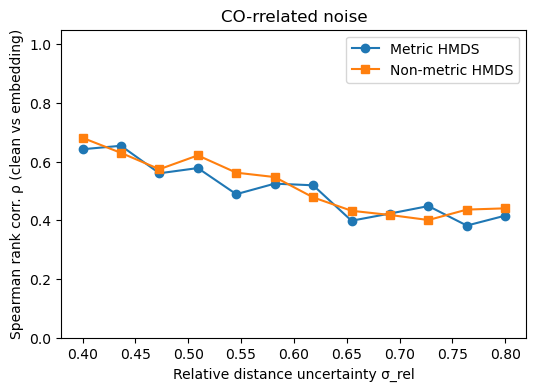

In [59]:

# ---------------------------------------------------------
# 1.  Clean hyperbolic point cloud and distance matrix
# ---------------------------------------------------------
N    = 100
K    = -1.0                    # curvature |K|=1  ⇒ radius≈1
Rmax = 5.0                     # radial cut‑off used in h_samp
D    = 3                       # embed‑dimension
Ns = 5

pts  = np.asarray([h_samp(Rmax, D) for _ in range(N)])
dmat = np.zeros((N, N), dtype=np.float32)

for i in range(N):
    for j in range(i + 1, N):
        dij = pdist(pts[i], pts[j]).numpy() if tf.is_tensor(pts[i]) else pdist(pts[i], pts[j])
        dmat[i, j] = dmat[j, i] = dij

dmat = dmat/np.max(dmat)

# ---------------------------------------------------------
# 2.  Helper: build a noisy distance matrix for a given σ_rel
# ---------------------------------------------------------
def make_noisy_dmat(dmat, sigma_rel, sin_amp=10.0):
    """
    Parameters
    ----------
    dmat : (N,N) ndarray – clean hyperbolic distances
    sigma_rel : float      – multiplicative noise level (e.g. 0.05 ⇒ 5 % std)
    sin_amp : float        – amplitude of the sin non‑linearity you wanted

    Returns
    -------
    Noisy_dmat : (N,N) ndarray (symmetric, diag=0)
    """
    N = dmat.shape[0]
    Nd = np.zeros_like(dmat, dtype=np.float32)

    for i in range(N):
        for j in range(i + 1, N):
            base = dmat[i, j]
            nonlinear = sin_amp * np.sin(np.pi * base / 20.0)  # monotonic distorter
            noisy = base + np.random.normal(0.0, sigma_rel*base)
            Nd[i, j] = Nd[j, i] = noisy

    Nd = Nd/np.max(Nd)

    return Nd

# ---------------------------------------------------------
# 3.  Experimental sweep over uncertainty levels
# ---------------------------------------------------------
rel_sigmas = np.linspace(0.4, 0.8, 12)          # 1 % … 40 % noise
rho_metric, rho_nonmetric = [], []

for s in rel_sigmas:
    Noisy = make_noisy_dmat(dmat, sigma_rel=s)

    # ---- Metric HMDS -------------------------------------------------------
    hm = HMDS(Noisy, D=D)
    hm.train(10_000)                         # adjust / early‑stop as needed

    # Pairwise distances from the learned embedding (tensor → numpy)
    d_emb_hm = hm.pairwise_dist_lorentz().numpy()

    # ---- Non‑metric HMDS ----------------------------------------------------
    nm = nonmetricHMDS(Noisy, D=D, Ns = Ns)
    nm.train(10_000)

    d_emb_nm = nm.pairwise_dist_lorentz().numpy()  # g(·) is monotone ⇒ rank unchanged

    # ---- Rank correlations --------------------------------------------------
    iu = np.triu_indices(N, k=1)                   # upper‑triangle indices

    rho_hm, _ = spearmanr(dmat[iu], d_emb_hm[iu])
    rho_nm, _ = spearmanr(dmat[iu], d_emb_nm[iu])

    rho_metric.append(rho_hm)
    rho_nonmetric.append(rho_nm)

    print(f"σ_rel={s:0.3f} →  ρ_metric={rho_hm:0.4f},  ρ_nonmetric={rho_nm:0.4f}")

# ---------------------------------------------------------
# 4.  Plot
# ---------------------------------------------------------

plt.figure(figsize=(6,4))
plt.plot(rel_sigmas, rho_metric,    marker='o', label='Metric HMDS')
plt.plot(rel_sigmas, rho_nonmetric, marker='s', label='Non‑metric HMDS')
plt.xlabel('Relative distance uncertainty σ_rel')
plt.ylabel("Spearman rank corr. ρ (clean vs embedding)")
plt.ylim(0, 1.05)
plt.legend()
plt.title('CO-rrelated noise')
plt.show()


epoch 0, Loss: 8103.9423828125, normG: 38296.93359375
epoch 5000, Loss: -3600.481201171875, normG: 5930.25
epoch 0, Loss: 7770.73876953125, normG: 153977.015625
epoch 5000, Loss: -6419.748046875, normG: 7593.80859375
σ_rel=0.010 →  ρ_metric=0.9710,  ρ_nonmetric=0.9341
epoch 0, Loss: 8112.9833984375, normG: 37780.73828125
epoch 5000, Loss: -2911.94921875, normG: 4707.46533203125
epoch 0, Loss: 7779.2841796875, normG: 153658.421875
epoch 5000, Loss: -5584.86474609375, normG: 919.7669067382812
σ_rel=0.087 →  ρ_metric=0.9678,  ρ_nonmetric=0.9748
epoch 0, Loss: 8121.5556640625, normG: 37095.78125
epoch 5000, Loss: -1825.2353515625, normG: 2128.98486328125
epoch 0, Loss: 7788.13134765625, normG: 152441.9375
epoch 5000, Loss: -2702.610107421875, normG: 315.4571228027344
σ_rel=0.163 →  ρ_metric=0.9595,  ρ_nonmetric=0.9297
epoch 0, Loss: 8143.06689453125, normG: 35902.77734375
epoch 5000, Loss: -790.5335693359375, normG: 950.5355224609375
epoch 0, Loss: 7809.865234375, normG: 150372.328125
epoc

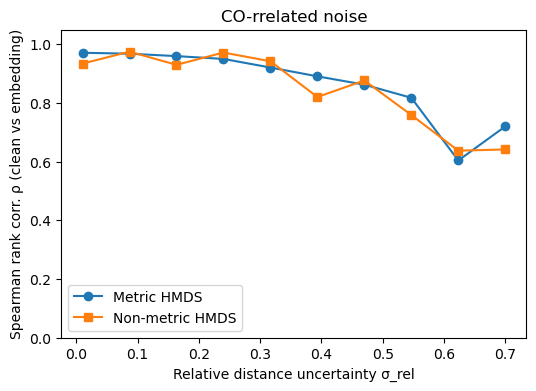

In [60]:

# ---------------------------------------------------------
# 1.  Clean hyperbolic point cloud and distance matrix
# ---------------------------------------------------------
N    = 100
K    = -1.0                    # curvature |K|=1  ⇒ radius≈1
Rmax = 5.0                     # radial cut‑off used in h_samp
D    = 3                       # embed‑dimension
Ns = 5

pts  = np.asarray([h_samp(Rmax, D) for _ in range(N)])
dmat = np.zeros((N, N), dtype=np.float32)

for i in range(N):
    for j in range(i + 1, N):
        dij = pdist(pts[i], pts[j]).numpy() if tf.is_tensor(pts[i]) else pdist(pts[i], pts[j])
        dmat[i, j] = dmat[j, i] = dij

dmat = dmat/np.max(dmat)

# ---------------------------------------------------------
# 2.  Helper: build a noisy distance matrix for a given σ_rel
# ---------------------------------------------------------
def make_noisy_dmat(dmat, sigma_rel, sin_amp=10.0):
    """
    Parameters
    ----------
    dmat : (N,N) ndarray – clean hyperbolic distances
    sigma_rel : float      – multiplicative noise level (e.g. 0.05 ⇒ 5 % std)
    sin_amp : float        – amplitude of the sin non‑linearity you wanted

    Returns
    -------
    Noisy_dmat : (N,N) ndarray (symmetric, diag=0)
    """
    N = dmat.shape[0]
    Nd = np.zeros_like(dmat, dtype=np.float32)

    for i in range(N):
        for j in range(i + 1, N):
            base = dmat[i, j]
            nonlinear = sin_amp * np.sin(np.pi * base / 20.0)  # monotonic distorter
            noisy = nonlinear + np.random.normal(0.0, sigma_rel*base)
            Nd[i, j] = Nd[j, i] = noisy

    #Nd = Nd/np.max(Nd)

    return Nd

# ---------------------------------------------------------
# 3.  Experimental sweep over uncertainty levels
# ---------------------------------------------------------
rel_sigmas = np.linspace(0.01, 0.7, 10)          # 1 % … 40 % noise
rho_metric, rho_nonmetric = [], []

for s in rel_sigmas:
    Noisy = make_noisy_dmat(dmat, sigma_rel=s)

    # ---- Metric HMDS -------------------------------------------------------
    hm = HMDS(Noisy, D=D)
    hm.train(10_000)                         # adjust / early‑stop as needed

    # Pairwise distances from the learned embedding (tensor → numpy)
    d_emb_hm = hm.pairwise_dist_lorentz().numpy()

    # ---- Non‑metric HMDS ----------------------------------------------------
    nm = nonmetricHMDS(Noisy, D=D, Ns = Ns)
    nm.train(10_000)

    d_emb_nm = nm.pairwise_dist_lorentz().numpy()  # g(·) is monotone ⇒ rank unchanged

    # ---- Rank correlations --------------------------------------------------
    iu = np.triu_indices(N, k=1)                   # upper‑triangle indices

    rho_hm, _ = spearmanr(dmat[iu], d_emb_hm[iu])
    rho_nm, _ = spearmanr(dmat[iu], d_emb_nm[iu])

    rho_metric.append(rho_hm)
    rho_nonmetric.append(rho_nm)

    print(f"σ_rel={s:0.3f} →  ρ_metric={rho_hm:0.4f},  ρ_nonmetric={rho_nm:0.4f}")

# ---------------------------------------------------------
# 4.  Plot
# ---------------------------------------------------------

plt.figure(figsize=(6,4))
plt.plot(rel_sigmas, rho_metric,    marker='o', label='Metric HMDS')
plt.plot(rel_sigmas, rho_nonmetric, marker='s', label='Non‑metric HMDS')
plt.xlabel('Relative distance uncertainty σ_rel')
plt.ylabel("Spearman rank corr. ρ (clean vs embedding)")
plt.ylim(0, 1.05)
plt.legend()
plt.title('CO-rrelated noise')
plt.show()

